# Neural Ordinary Differential Equations
## Summary

NeurIPS is the largest AI conference in the world. 4,854 papers were submitted. 4 received "Best paper" award. This is one of them. The basic idea is that neural networks are made up of stacked layers of simple computation nodes that work together to approximate a function. If we re-frame a neural network as an "Ordinary Differential Equation", we can use existing ODE solvers (like Euler's method) to approximate a function. This means no discrete layers, instead the network is a continous function. No more specifying the # of layers beforehand, instead specify the desired accuracy, it will learn how to train itself within that margin of error. It's still early stages, but this could be as big a breakthrough as GANs! 

<table>
    <tr>
        <td> <img src="images/resnet_0_viz.png" alt="Drawing" style="width: 450px;"/> </td>
        <td> <img src="images/odenet_0_viz.png" alt="Drawing" style="width: 450px;"/> </td>
    </tr>
</table>

 -  Left: A Residual network defines a discrete sequence of finite transformations.
 -  Right: A ODE network defines a vector field, which continuously transforms the state.
 -  Both: Circles represent evaluation locations

## Demo 
An ODENet approximated this spiral function better than a Recurrent Network. 

![alt text](images/demon-timeseries.png)

ODENet give comparable result to ResNet but cheaper in memory
![Ode vs ResNet](images/resnet-vs-ode.png)


## Why Does this matter? 

1. Faster testing time than recurrent networks, but slower training time. Perfect for low power edge computing! (precision vs speed)
2. More accurate results for time series predictions (!!) i.e continous-time models
3. Opens up a whole new realm of mathematics for optimizing neural networks (Diff Equation Solvers, 100+ years of theory)
4, Compute gradients with constant memory cost

## Resources
 - Paper: https://nips.cc/Conferences/2018/Schedule?showEvent=11635
 - Siraj Rava github: https://github.com/llSourcell/Neural_Differential_Equations
 - torchdiffeq in github: https://github.com/rtqichen/torchdiffeq

To install torchdiffeq:
pip install git+https://github.com/rtqichen/torchdiffeq.git



# Neural Network, Global Approximators

From Universal Approximation Theorem, a network made of linear matrix multiplication followed by a non-linear function can approximate any arbitrary continuous function. 

# Residual Neural Network

A solution to this was proposed by Microsoft for the 2015 ImageNet competiton (residual networks)
- In December of  2015, Microsoft proposed "Residual networks" as a solution to the ImageNet Classification Competition
- ResNets had the best accuracy in the competition
- ResNets utilize "skip-connections" between layers, which increases accuracy.
- They were able to train networks of up to 1000 layers deep while avoiding vanishing gradients (lower accuracy)
- 6 months later, their publicatio already had more than 200 references.

The residual layer is actually quite simple: add the output of the activation function to the original input to the layer. As a formula, the k+1th layer has the formula:

\begin{equation} x_{k+1} = x_{k} + F(x_{k})\end{equation}

where F is the function of the kth layer and its activation. For example, F might represent a convolutional layer with a relu activation. This simple formula is a special case of the formula:

\begin{equation} x_{k+1} = x_{k} + h F(x_k),\end{equation}

which is the formula for the Euler method for solving ordinary differential equations (ODEs) when h=1

# Euler Expansion

Consider a simplified ODE from physics: we want to model the position x of a marble. Assume we can calculate its velocity x′ (the derivative of position) at any position x. We know that the marble starts at rest x(0)=0 and that its velocity at time t depends on its position through the formula:

\begin{equation} \dot{x}(t) = f(x) \end{equation}

The Euler method solves this problem by following the physical intuition: my position at a time very close to the present depends on my current velocity and position. For example, if you are travelling at a velocity of 5 meters per second, and you travel 1 second, your position changes by 5 meters. If we travel h seconds, we will have travelled 5h meters. As a formula, we said:

\begin{equation}x(t+h) = x(t) + h \dot{x}(t),\end{equation}

but since we know

\begin{equation} \dot{x}(t) = f(x) \end{equation}

we can rewrite this as

\begin{equation} x(t+h) = x(t) + h f(x).\end{equation}

If you squint at this formula for the Euler method, you can see it looks just like the formula for residual layers!

This observation has meant three things for designing neural networks:

- New neural network layers can be created through different numerical approaches to solving ODEs
- The possibility of arbitrarily deep neural networks
- Training of a deep network can be improved by considering the so-called stability of the underlying ODE and its numerical discretization




## What Does an ODENet Look like? 

*An ODE is a function that usually describes the change of some system through time. In this setting, time is a continuous variable. Now imagine a neural network is that system, and time is really something more like the depth of the network. Note that there are usually a discrete number of layers in an ANN. This is a notion of continuous number of layers.*

- The team didn't use Euler's method, they computed the exact ODE solution (within a small error tolerance) using adaptive solvers (faster)
- The dynamics change smoothly with depth. You can think of this either as having weights that are a function of depth, or as having shared weights across layers but adding the depth as an extra input to f.
- Anywhere you can put a resnet you can put an ODEnet.
- Each ODEBlock can be used to replace a whole stack of ResBlocks.
- In their MNIST example, each ODEBlock replaces 6 ResBlocks.

### Traditional Deep Nets


```
h1 = f1(x)
h2 = f2(h1)
h3 = f3(h2)
h4 = f3(h3)
y  = f5(h4)
```

### ResNets

```
h1 = f1(x)  + x
h2 = f2(h1) + h1
h3 = f3(h2) + h2
h4 = f4(h3) + h3
y  = f5(h4) + h4
```


- Where f1, f2, etc are neural net layers.
- The idea is that it's easier to model a small change to an almost-correct answer than to output the whole improved answer at once.
-This looks like a primitive ODE solver (Euler's method) that solves the trajectory of a system by just taking small steps in the direction of the system dynamics and adding them up.
-They connection allows for better training methods.
- What if we define a deep net as a continuously evolving system? 
- Instead of updating the hidden units layer by layer, we define their derivative with respect to depth instead
- We can use off-the-shelf adaptive ODE solvers to compute the final state of these dynamics, and call that the output of the neural network. 




## Reverse-mode automatic differentiation of ODE solution
The main technical difficulty in training continuous-depth is performing revese-mode differentiation (backpropagation) through ODE solver. Differentiation through the operation fo hte forward pass is straightforward, but incurs a high memory cost and intrdouces additional numerical cost.




### The Adjoint Method
Consider optimising a scalar-valued loss function $L()$, whose input is the result of an ODE solver

\begin{equation}
    L(z(t_1)) = L(\text{ODESolve}(z(t_0),f,t_0,t_1,\theta))
\end{equation}

To optimise $L$, we require the gradient with respect to parameters: $z(t_0), t_0, t_1,\text{and } \theta$.

- This approach computes gradients by solving a second, augmented ODE backwards in time, and is applicable to all ODE solvers. 
- This approach scales linearly with problem size, has low memory cost, and explicitly controls numerical error.
- The adjoint captures how the loss function L changes with respect to the hidden state.
- Starting from the output of the network, we can recompute the hidden state backwards in time together with the adjoint.



![NODE-Fig 1](images/NODEs-Fig-2.jpeg)

- A third integral then tells us how the loss changes with the parameters \theta ( dL/d\theta).
- All three of these integrals can be computed in a single call to an ODE solver, which concatenates the original state, the adjoint, and the other partial derivatives into a single vector. 
- Algorithm 1 shows how to construct the necessary dynamics, and call an ODE solver to compute all gradients at once.

![NODE fig 2](images/NODEs-Alg-1.jpeg)


### Implementation

- To create arbitrarily deep networks with a finite memory footprint, design neural networks based on stable ODEs and numerical discretizations.
- Create ODEFunc class to calculate the dervivative
- Call ODENet black box function inside a ODEBlock class


# Latent ODE

In [1]:
%matplotlib inline

In [2]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
niters = 2000
lr = 0.01
gpu = 0
train_dir = 'data'

In [4]:
from torchdiffeq import odeint
#from torchdiffeq import odeint_adjoint as odeint

In [5]:
def func( t, y):
    yd = t
    return yd

odeint(func, torch.tensor([0.0]), torch.tensor([0.0, 1.0]))

tensor([[0.0000],
        [0.5000]])

$$\frac{dy}{dt} = t$$
$$y_0 = 0.0$$
$$y-y_0=\int_0^1t\times dt$$
$$y = \left.\frac{t^2}{2}\right|_0^1= 0.5$$

### Generate trajectory

In [6]:
def generate_spiral2d(nspiral=1000,
                      ntotal=500,
                      nsample=100,
                      start=0.,
                      stop=1,  # approximately equal to 6pi
                      noise_std=.1,
                      a=0.,
                      b=1.,
                      savefig=True):
    """Parametric formula for 2d spiral is `r = a + b * theta`.
    Args:
      nspiral: number of spirals, i.e. batch dimension
      ntotal: total number of datapoints per spiral
      nsample: number of sampled datapoints for model fitting per spiral
      start: spiral starting theta value
      stop: spiral ending theta value
      noise_std: observation noise standard deviation
      a, b: parameters of the Archimedean spiral
      savefig: plot the ground truth for sanity check
    Returns: 
      Tuple where first element is true trajectory of size (nspiral, ntotal, 2),
      second element is noisy observations of size (nspiral, nsample, 2),
      third element is timestamps of size (ntotal,),
      and fourth element is timestamps of size (nsample,)
    """

    # add 1 all timestamps to avoid division by 0
    orig_ts = np.linspace(start, stop, num=ntotal)
    samp_ts = orig_ts[:nsample]

    # generate clock-wise and counter clock-wise spirals in observation space
    # with two sets of time-invariant latent dynamics
    zs_cw = stop + 1. - orig_ts
    rs_cw = a + b * 50. / zs_cw
    xs, ys = rs_cw * np.cos(zs_cw) - 5., rs_cw * np.sin(zs_cw)
    orig_traj_cw = np.stack((xs, ys), axis=1)

    zs_cc = orig_ts
    rw_cc = a + b * zs_cc
    xs, ys = rw_cc * np.cos(zs_cc) + 5., rw_cc * np.sin(zs_cc)
    orig_traj_cc = np.stack((xs, ys), axis=1)

    if savefig:
        plt.figure()
        plt.plot(orig_traj_cw[:, 0], orig_traj_cw[:, 1], label='clock')
        plt.plot(orig_traj_cc[:, 0], orig_traj_cc[:, 1], label='counter clock')
        plt.legend()
        plt.savefig('./ground_truth.png', dpi=500)
        print('Saved ground truth spiral at {}'.format('./ground_truth.png'))

    # sample starting timestamps
    orig_trajs = []
    samp_trajs = []
    for _ in range(nspiral):
        # don't sample t0 very near the start or the end
        t0_idx = npr.multinomial(
            1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
        t0_idx = np.argmax(t0_idx) + nsample

        cc = bool(npr.rand() > .5)  # uniformly select rotation
        orig_traj = orig_traj_cc if cc else orig_traj_cw
        orig_trajs.append(orig_traj)

        samp_traj = orig_traj[t0_idx:t0_idx + nsample, :].copy()
        samp_traj += npr.randn(*samp_traj.shape) * noise_std
        samp_trajs.append(samp_traj)

    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    return orig_trajs, samp_trajs, orig_ts, samp_ts

### ODE Function
This is the function that corresponds to derivative, create a block that you need to integrate like in ResNet (ResNet Block you keep repeating)

In [7]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out

In [8]:
class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

In [9]:
class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [10]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


In [11]:
def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


# Variational autoencoder (VAE)
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

Let’s define some notions:
1. $X$: data that we want to model a.k.a the animal
2. $z$: latent variable a.k.a our imagination
3. $p(X)$: probability density of the data, i.e. that animal kingdom
4. $p(z)$: probability density of latent variable, i.e. our brain, the source of our imagination
5. $p(X|z)$: probability density of generating data given latent variable, e.g. turning imagination into real animal


Our objective here is to model the data, hence we want to find $p(X)$ Using the law of probability, we could find it in relation with $z$ as follows:
<h1><center>$p(X) = \int p(X|z)p(z)dz$</center></h1>
that is, we marginalize out $z$ from the joint probability distribution $P(X,z)$.

The idea of VAE is to infer $p(z)$ using $p(z|X)$. This is make a lot of sense if we think about it: we want to make our latent variable likely under our data. Talking in term of our fable example, we want to limit our imagination only on animal kingdom domain, so we shouldn’t imagine about things like root, leaf, tyre, glass, GPU, refrigerator, doormat, … as it’s unlikely that those things have anything to do with things that come from the animal kingdom. Right?

But the problem is, we have to infer that density  $p(z|X)$, as we don’t know it yet. In VAE, as it name suggests, we infer $p(z|X)$ using a method called Variational Inference (VI). VI is one of the popular choice of method in bayesian inference, the other one being MCMC method. The main idea of VI is to pose the inference by approach it as an optimization problem. How? By modeling the true density $p(z|X)$ using simpler density that is easy to evaluate, e.g. Gaussian, and minimize the difference between those two density using KL divergence metric, which tells us how difference it is $p$ and $q$.

What we are trying to do is encode the sequence into latent variables, which are parameters to Normal distribution and then use that in the decoder. The decoder will be ODE network.

![vae](images/NODEs-Fig-6.jpeg)

# Kullback–Leibler divergence
Alright, now let’s say we want to infer $p(z|X)$ using $q(z|X)$. The KL divergence then formulated as follows:
<h1><center>$D_{KL}[q[z|X)||p(z|X)] = \sum_z q(z|X) \log \frac{q(z|X)}{p(z|X)} = E_q[\log q(z|X) - \log p(z|X)]$</center></h1>
# What KL-Divergence do?
* allows use to compare 2 probability distributions
* if $q$ is the same as  $p$, then KLD = 0
* if $q$ is different from  $p$, KLD > 0

# The cost function
The cost function we want to minimise is the negative of the evidence lower bound: 'ELBO':
<h1><center>$ELBO = E[\log p(X|z)] - D_{KL} [q(z|X) ||p(z)]$</center></h1>

![elbo](images/elbo.png)

The first term is $E_q[\log p(X|z)]$ is the cross entropy we know. 
The second term is the KL divergence between the prior $p(z)$ and our latent model. We can choose the prior density any density we want, but it is much simpler to use normal density function: $p(z) = \mathcal{N}(0,1)$. 

# KL distribution between two normal distribution
I am using book: The Matrix Cookbook from: http://coin.wne.uw.edu.pl/pbiernacki/matrix_cookbook.pdf
1. $q(z|X) = \mathcal{N}(\mu_1, \Sigma_1^2)$
2. $p(z) = \mathcal{N}(\mu_2, \Sigma_2^2)$
3. $D_{KL}[q(z|X)||p(z:X)] = \int p(z) [\log p(z) - \log q(z|X)] dz$
4. $D_{KL}[\mathcal{N}(\mu_1, \Sigma_1)||\mathcal{N}(\mu_2,\Sigma_2)]= \frac{1}{2} [\log \frac{|\Sigma_2|}{|\Sigma_1|} - d  + tr{\Sigma_2^{-1}\Sigma_1} + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1)]$
4. $d$ is the dimension of the latent vector.

If we have $d=1$, and $p(x) = \mathcal{N}(0,1)$ then the formula becomes very simple.
$KL [\mathcal{N}(\mu, \Sigma^2) || \mathcal{N}(0,1)  ] = \frac{1}{2}(\log(\Sigma) -1  + \Sigma + \mu^2)$ 

In [15]:
#tensor flow allows you to get the KL between two distribution...
#pip install --upgrade tensorflow-probability
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
Normal = tfp.distributions.Normal
t = tfp.distributions.kl_divergence(Normal(3.0, 2.0), Normal(0.0, 1.0))
t2 = tfp.distributions.kl_divergence(Normal(3.0, 1.0), Normal(2.9,1.0))
t3 = tfp.distributions.kl_divergence(Normal(3.0, 1.0), Normal(3.0,1.0))
import gc
#Multivariate Normal distribution
mu1 =np.array( [1.,2])
cov1=np.array([[3,3/5], [3/5,2]])


mu2 = np.array([4,2.1])
cov2= np.array([[1,3/5], [3/5,2]])

tmvn = tfp.distributions.kl_divergence(tfp.distributions.MultivariateNormalFullCovariance(loc=mu1,covariance_matrix=cov1),
        tfp.distributions.MultivariateNormalFullCovariance(
           loc=mu2,
           covariance_matrix=cov2) )

print('KLD(N(3,2), N(0,1)) =', t, ", value = ", .5*(np.log(2)  - 1  + 2.0 + 3**2 ))
print('KLD(N(3,1), N(2.9,1)) =', t2)
print('KLD(N(3,1), N(3,1)) =', t3)
print('KLD(MVN1, MVN2)  = ', tmvn)



KLD(N(3,2), N(0,1)) = tf.Tensor(5.306853, shape=(), dtype=float32) , value =  5.346573590279973
KLD(N(3,1), N(2.9,1)) = tf.Tensor(0.0049999906, shape=(), dtype=float32)
KLD(N(3,1), N(3,1)) = tf.Tensor(0.0, shape=(), dtype=float32)
KLD(MVN1, MVN2)  =  tf.Tensor(5.98301584426063, shape=(), dtype=float64)


$D_{KL}[\mathcal{N}(\mu_1, \Sigma_1)||\mathcal{N}(\mu_2,\Sigma_2)]= \frac{1}{2} [\log \frac{|\Sigma_2|}{|\Sigma_1|} - d  + tr{\Sigma_2^{-1}\Sigma_1} + (\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1)]$

In [12]:
import gc

dkl = 0.5*(np.log(np.linalg.det(cov2)/np.linalg.det(cov1) )- 2 + 
           np.trace(np.linalg.inv(cov2)@cov1) + np.transpose(mu2-mu1)@np.linalg.inv(cov2)@(mu2-mu1))
print(dkl)
gc.collect()

5.98301584426063


493

# Implementation of KL divergence



In [12]:
def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

Saved ground truth spiral at ./ground_truth.png


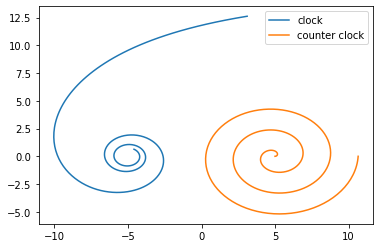

In [14]:
import torch
import gc
latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 1000
nsample = 100
gc.collect()
device = torch.device('cuda:' + str(gpu)
                      if torch.cuda.is_available() else 'cpu')

# generate toy spiral data
orig_trajs, samp_trajs, orig_ts, samp_ts = generate_spiral2d(
    nspiral=nspiral,
    start=start,
    stop=stop,
    noise_std=noise_std,
    a=a, b=b
)
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

# model
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

In [15]:
if train_dir is not None:
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    ckpt_path = os.path.join(train_dir, 'ckpt.pth')
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path)
        func.load_state_dict(checkpoint['func_state_dict'])
        rec.load_state_dict(checkpoint['rec_state_dict'])
        dec.load_state_dict(checkpoint['dec_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        orig_trajs = checkpoint['orig_trajs']
        samp_trajs = checkpoint['samp_trajs']
        orig_ts = checkpoint['orig_ts']
        samp_ts = checkpoint['samp_ts']
        print('Loaded ckpt from {}'.format(ckpt_path))





In [16]:
try:
    for itr in range(1, niters + 1):
        optimizer.zero_grad()
        # backward in time to infer q(z_0)
        h = rec.initHidden().to(device)
        for t in reversed(range(samp_trajs.size(1))):
            obs = samp_trajs[:, t, :]
            out, h = rec.forward(obs, h)
        qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(device)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

        # forward in time and solve ode for reconstructions
        pred_z = odeint(func, z0, samp_ts).permute(1, 0, 2)
        pred_x = dec(pred_z)

        # compute loss
        noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
        noise_logvar = 2. * torch.log(noise_std_).to(device)
        logpx = log_normal_pdf(
            samp_trajs, pred_x, noise_logvar).sum(-1).sum(-1)
        pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
        analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                pz0_mean, pz0_logvar).sum(-1)
        print(analytic_kl.shape, logpx.shape)
        loss = torch.mean(-logpx + analytic_kl, dim=0)
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item())

        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -loss_meter.avg))

except KeyboardInterrupt:
    if train_dir is not None:
        ckpt_path = os.path.join(train_dir, 'ckpt.pth')
        torch.save({
            'func_state_dict': func.state_dict(),
            'rec_state_dict': rec.state_dict(),
            'dec_state_dict': dec.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'orig_trajs': orig_trajs,
            'samp_trajs': samp_trajs,
            'orig_ts': orig_ts,
            'samp_ts': samp_ts,
        }, ckpt_path)
        print('Stored ckpt at {}'.format(ckpt_path))
print('Training complete after {} iters.'.format(itr))

torch.Size([1000]) torch.Size([1000])
Iter: 1, running avg elbo: -19002.5137
torch.Size([1000]) torch.Size([1000])
Iter: 2, running avg elbo: -18997.6068
torch.Size([1000]) torch.Size([1000])
Iter: 3, running avg elbo: -18984.4057
torch.Size([1000]) torch.Size([1000])
Iter: 4, running avg elbo: -18954.9679
torch.Size([1000]) torch.Size([1000])
Iter: 5, running avg elbo: -18902.4571
torch.Size([1000]) torch.Size([1000])
Iter: 6, running avg elbo: -18822.0280
torch.Size([1000]) torch.Size([1000])
Iter: 7, running avg elbo: -18726.4907
torch.Size([1000]) torch.Size([1000])
Iter: 8, running avg elbo: -18636.0205
torch.Size([1000]) torch.Size([1000])
Iter: 9, running avg elbo: -18534.4299
torch.Size([1000]) torch.Size([1000])
Iter: 10, running avg elbo: -18422.9114
torch.Size([1000]) torch.Size([1000])
Iter: 11, running avg elbo: -18308.9401
torch.Size([1000]) torch.Size([1000])
Iter: 12, running avg elbo: -18195.3058
torch.Size([1000]) torch.Size([1000])
Iter: 13, running avg elbo: -18082.

Saved visualization figure at ./vis.png


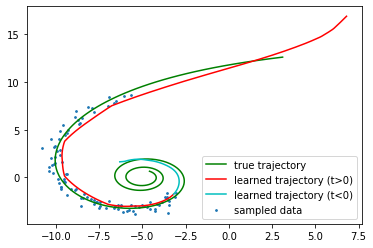

In [25]:
with torch.no_grad():
    # sample from trajectorys' approx. posterior
    h = rec.initHidden().to(device)
    for t in reversed(range(samp_trajs.size(1))):
        obs = samp_trajs[:, t, :]
        out, h = rec.forward(obs, h)
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
    orig_ts = torch.as_tensor(np.array(orig_ts.cpu()).astype('float')).to(device)
    #orig_ts = torch.from_numpy(orig_ts).float().to(device)

    # take first trajectory for visualization
    z0 = z0[0]

    ts_pos = np.linspace(0., 2. * np.pi, num=2000)
    ts_neg = np.linspace(-np.pi, 0., num=2000)[::-1].copy()
    ts_pos = torch.from_numpy(ts_pos).float().to(device)
    ts_neg = torch.from_numpy(ts_neg).float().to(device)

    zs_pos = odeint(func, z0, ts_pos)
    zs_neg = odeint(func, z0, ts_neg)

    xs_pos = dec(zs_pos)
    xs_neg = torch.flip(dec(zs_neg), dims=[0])

xs_pos = xs_pos.cpu().numpy()
xs_neg = xs_neg.cpu().numpy()
orig_traj = orig_trajs[0].cpu().numpy()
samp_traj = samp_trajs[0].cpu().numpy()

plt.figure()
plt.plot(orig_traj[:, 0], orig_traj[:, 1],
         'g', label='true trajectory')
plt.plot(xs_pos[:, 0], xs_pos[:, 1], 'r',
         label='learned trajectory (t>0)')
plt.plot(xs_neg[:, 0], xs_neg[:, 1], 'c',
         label='learned trajectory (t<0)')
plt.scatter(samp_traj[:, 0], samp_traj[
            :, 1], label='sampled data', s=3)
plt.legend()
plt.savefig('./vis.png', dpi=500)
print('Saved visualization figure at {}'.format('./vis.png'))

In [26]:
z = zs_pos.cpu().numpy()

In [27]:
print(z.shape)

(2000, 4)


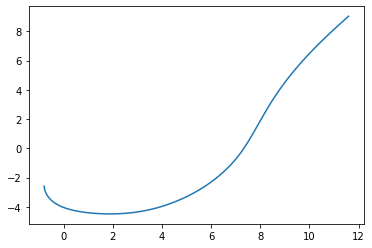

In [28]:
plt.plot(z[:,1], z[:,2])

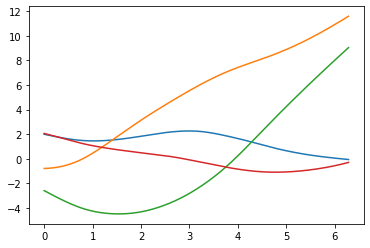

In [29]:
plt.plot(ts_pos.cpu().numpy(),z[:,0])
plt.plot(ts_pos.cpu().numpy(),z[:,1])
plt.plot(ts_pos.cpu().numpy(),z[:,2])
plt.plot(ts_pos.cpu().numpy(),z[:,3])